## Chapter 2 - Exercises

In [11]:
# setting the seed number so I can compare my answers to book's results.
import numpy as np
np.random.seed(42)

## 1. 
Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyperparameters, such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [12]:
import pandas as pd

housing = pd.read_csv('datasets/housing/housing.csv')

In [13]:
# create a column for 5 income groups

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [14]:
# Create stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
housing = strat_train_set.drop("median_house_value", axis=1) # predictions
housing_labels = strat_train_set["median_house_value"].copy() # labels

In [15]:
# Now that we've separated the train and test sets, 
# drop column created to turn the data back to its original state
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
# preparing a tranformer class:

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
        population_per_household = X[:, population_ix] / X[:, households_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), 
                         ('attribs_adder', CombinedAttributesAdder()), 
                         ('std_scaler', StandardScaler())])

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

housing_num = housing.drop('ocean_proximity', axis=1)
num_attribs = list(housing_num)

cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)

In [19]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)

SVR()

In [20]:
from sklearn.metrics import mean_squared_error

housing_prediction = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_prediction)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118455.13476469375

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svm_reg = SVR()

param_grid = [
  {
      'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0], 'kernel': ['linear']
  },
  {
      'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0], 
      'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0], 
      'kernel': ['rbf']}
      ]

grid = GridSearchCV(svm_reg, param_grid=param_grid, cv=5, n_jobs=-1, 
                    scoring='neg_mean_squared_error', verbose=2)

grid.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 20.8min finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [22]:
negative_mse = grid.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70338.36756805143

In [23]:
grid.best_params_

{'C': 1000.0, 'kernel': 'linear'}

In [24]:
# evaluation scores
cvres = grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

81649.4933206491 {'C': 10.0, 'kernel': 'linear'}
74344.25372740348 {'C': 30.0, 'kernel': 'linear'}
71235.18700401639 {'C': 100.0, 'kernel': 'linear'}
70485.58977342138 {'C': 300.0, 'kernel': 'linear'}
70338.36756805143 {'C': 1000.0, 'kernel': 'linear'}
70346.3175689201 {'C': 3000.0, 'kernel': 'linear'}
70366.12439508669 {'C': 10000.0, 'kernel': 'linear'}
70361.65894739094 {'C': 30000.0, 'kernel': 'linear'}
118743.74833054295 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
118581.24055475516 {'C': 1.0, 'gamma': 0.03, 'kernel': 'rbf'}
118556.82411885096 {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
118764.37910427665 {'C': 1.0, 'gamma': 0.3, 'kernel': 'rbf'}
118894.65726808914 {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
118918.06616121177 {'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}
118398.06973905365 {'C': 3.0, 'gamma': 0.01, 'kernel': 'rbf'}
117911.51997815768 {'C': 3.0, 'gamma': 0.03, 'kernel': 'rbf'}
117816.57261693868 {'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}
118441.34978932199 {'C': 3.0, 'gamma'

Best perfomance: 70338.36756805143 {'C': 1000.0, 'kernel': 'linear'}

## 2. 
Try replacingGridSearchCV with RandomizedSearchCV.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# After running my own version, and getting not so good results,
# I took a look at the book's answers to see what parameters the author used.

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()

grid_rand = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, cv=5, 
                               n_jobs=-1, n_iter=50, scoring='neg_mean_squared_error', 
                               verbose=2, random_state=42)

grid_rand.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 31.1min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1243c72b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1243c77f0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [26]:
negative_mse = grid_rand.best_score_
rmse = np.sqrt(-negative_mse)
rmse

55215.341404932245

In [27]:
grid_rand.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.


Let's look at the exponential distribution we used, with scale=1.0. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

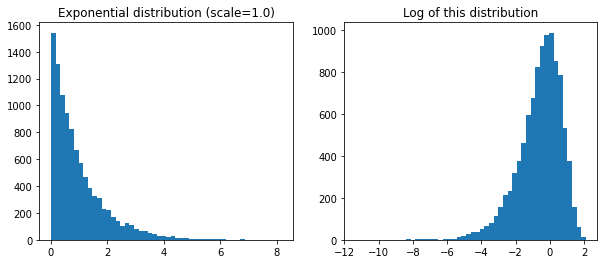

In [29]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for C looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:


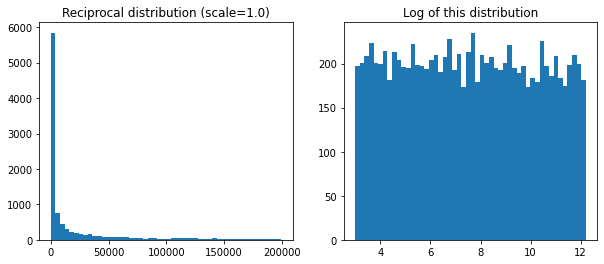

In [30]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.


## 3. 
Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [41]:
# From Chapter 2 Review. 
# As exercises are being done on a separate notebook, I had to hardcode this. 
# Will remeber this for future exercises and keep review + exercises on same notebook.

feature_importances = [6.79113775e-02, 6.21053438e-02, 4.18946162e-02, 1.53992085e-02,
                       1.46185686e-02, 1.58283227e-02, 1.44876656e-02, 3.55789420e-01,
                       5.22753875e-02, 1.12944671e-01, 6.20786832e-02, 9.88261664e-03,
                       1.67837214e-01, 7.68603101e-05, 3.95171743e-03, 2.91832708e-03]

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = ['<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']
num_attribs = list(housing_num)

attributes = num_attribs + extra_attribs + cat_one_hot_attribs


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [43]:
# Selecting top 5 features
k = 5

In [44]:
# Checking their indices
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [45]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'rooms_per_hhold',
       '<1H OCEAN'], dtype='<U18')

In [46]:
# Let's double check that these are indeed the top k features:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.35578942, 'median_income'),
 (0.167837214, '<1H OCEAN'),
 (0.112944671, 'rooms_per_hhold'),
 (0.0679113775, 'longitude'),
 (0.0621053438, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:


In [47]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [48]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:


In [49]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.31205452,  1.        ],
       [-1.17602483,  0.6596948 ,  1.33645936,  0.21768338,  1.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.46531516,  0.        ]])

Now let's double check that these are indeed the top k features:


In [50]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.31205452,  1.        ],
       [-1.17602483,  0.6596948 ,  1.33645936,  0.21768338,  1.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.46531516,  0.        ]])

It works, but I need to review it further.

**I couldn't find the solution by myself and had to resort to consulting book solutions.**

## 4.
Try creating a single pipeline that does the full data preparation plus the final prediction.

In [53]:
# basically, grouping questions 1, 2 and 3

whole_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**grid_rand.best_params_))
])

In [54]:
whole_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

In [56]:
# testing some values
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", whole_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [176948.59389828 338929.51545483 160147.78772776  56102.78935217]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


## 5.
Automatically explore some preparation options using GridSearchCV.

In [58]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(whole_pipeline, param_grid, cv=5, n_jobs=-1,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 33.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [59]:
grid_search_prep.best_params_

{'feature_selection__k': 16,
 'preparation__num__imputer__strategy': 'most_frequent'}

In general, my results are not the same, but pretty close to the book's solution.<br>
To do: investigate if some step was skipped and maybe try to reproduce it later.